# Modeling poisuielle flow using Navier-Stokes
Based on: [LINK](https://drzgan.github.io/Python_CFD/16.%20Poiseuille%20channel%20flow.html)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions, does not need to be rerun
# Creating the periodic boundary conditions
def build_up_b(rho,dt,dx,dy,u,v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b


# Pressure
def pressure_poisson_periodic(p,b, dx, dy,nit):
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
    
    return p

In [ ]:
##variable declarations
nx = 41
ny = 41
#nt = 10
nit = 80 
#c = 1
H = 2
dx = H / (nx - 1)
dy = H / (ny - 1)
x = np.linspace(0, H, nx)
y = np.linspace(0, H, ny)
X, Y = np.meshgrid(x, y)


##physical variables
rho = 2
nu = .01
mu = nu * rho

F = 1
dpdx = F * rho 
dt = .1

#initial conditions
u = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

p = np.ones((ny, nx))
pn = np.ones((ny, nx))

b = np.zeros((ny, nx))

# Run simulation for step amount
stepGoal = 3000
stepcount = 0

while stepGoal > stepcount:
    un = u.copy()
    vn = v.copy()

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p,b, dx, dy, nit)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Periodic BC u @ x = 2     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Periodic BC u @ x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Periodic BC v @ x = 2
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Periodic BC v @ x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :]=0
    
    udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
    #print(udiff)
    stepcount += 1

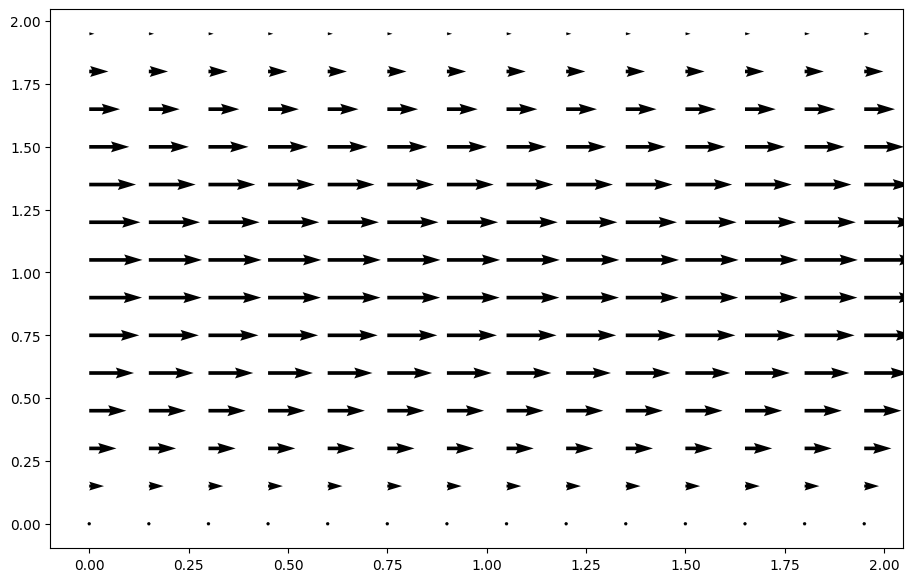

In [3]:
fig = plt.figure(figsize = (11,7), dpi=100)
plt.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3])

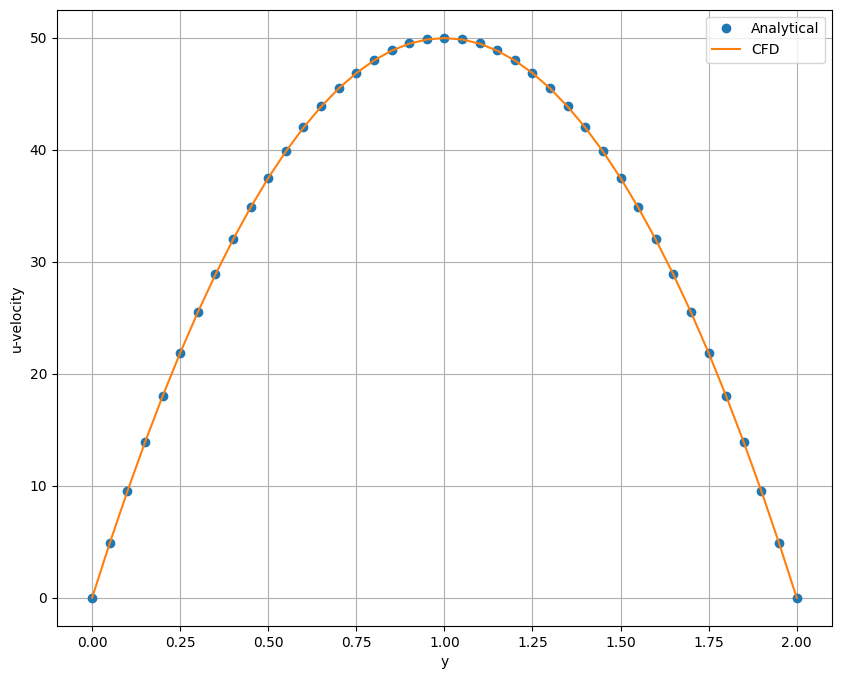

In [ ]:
u_ana = -dpdx / (2*mu) * y * (y - H)

# Plotting
plt.figure(figsize=(10,8))

plt.plot(y,u_ana, 'o', label='Analytical') # 
plt.plot(y,u[:,int(nx/2)], label='CFD') # 
plt.ylabel('u-velocity')
plt.xlabel('y')
#plt.title('u-velocity for different y and Re')
plt.legend()
plt.grid(True)
plt.show()